# 第19章 类型参数化
在本章，我们将介绍Scala类型参数化的细节。在这个过程中我们将通过一个具体的例子来展示第13章介绍过的信息隐藏的技巧：设计一个纯函数式的类。我们将一起呈现类型参数化和信息隐藏，因为信息隐藏可以被用于更通用的类型参数化型变注解。

类型参数化让我们能够编写泛型的类和特质。例如，集（set）是泛型的，接收一个类型参数：定义为Set[T]。这样，具体的集的实例可以是 Set[String]、Set[Int]等，不过它必须是某种类型的集。与Java不同，Scala并不允许原生类型，Scala要求我们给出类型参数。型变定义了参数化类型的继承关系，以Set[String]为例，型变定义了它是不是Set[AnyRef]的子类型。

本章包含三个部分。在第一部分中我们将开发一个表示纯函数式队列的数据结构。第二部分介绍将这个结构的内部表现细节隐藏起来的技巧。最后一个部分介绍类型参数的型变以及它跟信息隐藏的关系。

## 19.1 函数式队列
函数式队列是一个数据结构，它支持三种操作：
head 返回队列的第一个元素  
tail 返回除第一个元素外的队列  
enqueue 返回一个将给定元素追加到队尾的新队列

跟可变队列不同，函数式队列在新元素被追加时，其内容并不改变，而是会返回一个新的包含该元素的队列。本章的目标是创建一个名为Queue的类，使用起来的效果如下：  
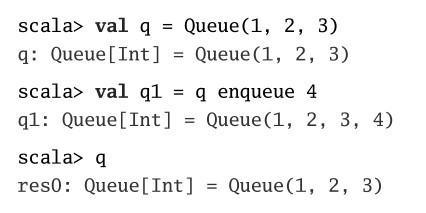  
如果Queue的实现是可变的，那么上述代码的第二步enqueue操作会影响q的内容。事实上，在操作过后，结果队列q1和原始队列q都将包含序列1,2,3,4。不过对于函数式队列而言，被追加的值只会出现在结果q1中，而不会出现在被执行该操作的队列q中。

纯函数式队列还跟列表有一些相似，它们都被称作完全持久化（fully persistent）的数据结构，在经过扩展或修改之后，老版本将继续保持可用。它们都支持head和tail操作。不过列表通常用：：操作在头部扩展，而队列在尾部扩展，用的是enqueue方法。

如何实现才是高效的呢？最理想的情况下，一个函数式（不可变）的队列跟一个指令式（可变）的队列相比不应该有从根本上更高的额外开销。也就是说，所有三个操作，head、tail和enqueue操作都应该以常量时间完成。

实现函数式队列的一种简单方式是用列表来作为表现类型。这样一来head和tail都只是简单地翻译成列表中相同的操作，而enqueue则通过列表拼接来实现。

这让我们得到下面的实现：

In [1]:
class SlowAppendQueue[T](elems: List[T]){//不高效
    def head = elems.head
    def tail = new SlowAppendQueue(elems.tail)
    def enqueue(x: T) = new SlowAppendQueue(elems ::: List(x))
}

defined class SlowAppendQueue

这个实现的问题出在enqueue操作上。它的时间开销跟队列中存放的元素数量成正比。如果想要常量时间的追加操作，可以尝试将底层列表中的元素顺序反转过来，这样最后追加的元素出现在列表的头部。这让我们得到下面的实现：

In [2]:
class SlowHeadQueue[T](smele: List[T]){//不高效
    def head = smele.last
    def tail = new SlowAppendQueue(smele.init)
    def enqueue(x: T) = new SlowHeadQueue(x :: smele)
}

defined class SlowHeadQueue

现在enqueue是常量时间了，但head和tail并不是。它们现在的时间开销跟队列中元素数量成正比了。

从这两个例子看，似乎并没有一个实现可以对所有三种操作都做到常量时间。事实上，这看上去几乎是不可能做到的。不过，将两种操作结合到一起，可以非常接近这 个目标。背后的理念是用leading和trailing两个列表来表示队列。leading列表包含队列中靠前的元素，而trailing列表包含队列中靠后的元素，按倒序排列。整个队列在任何时刻的内容都等于“leading :::trailing.reverse”。

现在，要追加一个元素，只需要用：：操作符将它追加到trailing，这样一来enqueue就是常量时间。这意味着，当一开始为空的队列通过接连的 enqueue操作初始化时，trailing列表会增长而leading会保持空的状态。接下来，在首次head或tail被执行到空的leading 列表之前，整个trailing列表被复制到leading，同时元素的顺序被反转。这是通过一个名为mirror的操作完成的。

示例19.1给出了使用该实现方案的队列。

In [3]:
  class Queue[T](
    private val leading: List[T], 
    private val trailing: List[T] 
  ) {
    private def mirror = 
      if (leading.isEmpty)
        new Queue(trailing.reverse, Nil)
      else
        this
  
    def head = mirror.leading.head
  
    def tail = { 
      val q = mirror 
      new Queue(q.leading.tail, q.trailing) 
    }
  
    def enqueue(x: T) = 
      new Queue(leading, x :: trailing)
      
    override def toString = 
      leading ::: trailing.reverse mkString ("Queue(", ", ", ")")
  }

defined class Queue

In [4]:
val q = new Queue[Int](List(1, 2), List(3, 4))
println(q)
println(q.head)
println(q.tail)

val q1 = q enqueue 5

Queue(1, 2, 4, 3)
1
Queue(2, 4, 3)


q: Queue[Int] = Queue(1, 2, 4, 3)
q1: Queue[Int] = Queue(1, 2, 4, 3, 5)

这个队列实现的复杂度如何呢？mirror操作的耗时跟队列元素的数量成正比，但仅当leading为空时才发生。如果leading为非空，那么它就直接 返回了。由于head和tail调用了mirror，它们的复杂度与队列长度也成线性关系。不过，随着队列变长，mirror被调用的频率也会变低。

的确，假定我们有一个长度为n的队列，其leading列表为空。那么mirror操作必须将一个长度为n的列表做一次反向拷贝。不过下一次mirror要 做任何工作都要等到leading列表再次变空时，这将发生在n次tail操作过后。这意味着可以让这n次tail操作“分担”1/n的mirror复杂 度，也就是常量时间的工作。假定head、tail和enqueue操作差不多以相同频次出现，那么摊销（amortized）复杂度对于每个操作而言就是常量的了。因此从渐进的视角看，函数式队列跟可变队列同样高效。

不过，对于这个论点，我们要附加两点说明。首先，这里探讨的只是渐进行为，常量因子可能会不一样。其次，这个论点基于head、tail和enqueue的调用频次差不多相同。如果head的调用比其他两个操作要频繁得多，那么这个论点就不成立，因为每次对head的调用都将牵涉用mirror重新组织列表这个昂贵的操作。第二点可以被避免，可以设计出这样一个函数式队列，在连续的head操作中，只有第一次需要重组。可以在本章末尾找到相关例子（示例 19.10）。

## 19.2 信息隐藏
示例19.1给出的Queue实现在效率上来说已经非常棒了。你可能会表示反对，因为为了达到这个效率，我们暴露了不必要的实现细节。全局可访问的 Queue构造方法接收两个列表作为参数，其中一个顺序还是反的：很难说这是一个直观的对队列的表示。我们需要对使用方代码隐藏这个构造方法。在本节，我们将展示在Scala中完成这个动作的几种方式。

### 私有构造方法和工厂方法

在Java中，我们可以通过标记为private来隐藏构造方法。在Scala中，主构造方法并没有显式的定义，它是通过类参数和类定义体隐式地定义的。尽管如此，还是可以通过在参数列表前加上private修饰符来隐藏主构造方法，如示例19.2所示：  

In [5]:
  class Queue[T] private ( //注意这里括号前的private
    private val leading: List[T],
    private val trailing: List[T]
  ) 
  {
    private def mirror = 
      if (leading.isEmpty) new Queue(trailing.reverse, Nil)
      else this
    def head = 
      mirror.leading.head
    def tail = { 
      val q = mirror; 
      new Queue(q.leading.tail, q.trailing) 
    }
    def append(x: T) = 
      new Queue(leading, x :: trailing)

    override def toString() =
      (leading ::: trailing.reverse) mkString ("Queue(", ", ", ")")
  }

defined class Queue

<center>示例19.2 通过标记为私有来隐藏主构造方法</center>  

**类名和参数之间的private修饰符表示Queue的构造方法是私有的**：它只能从类本身及其伴生对象访问。类名Queue依然是公有的，因此可以把它当作类型来使用，但不能调用其构造方法：  
```scala
val q = new Queue[Int](List(1, 2), List(3, 4))

cmd9.sc:1: constructor Queue in class Queue cannot be accessed in class Helper
val q = new Queue[Int](List(1, 2), List(3, 4))
        ^Compilation Failed

Compilation Failed
```
 

既然Queue类的主构造方法不能从使用方代码调用，我们需要别的方式来创建新的队列。一种可能的方式是添加一个**辅助构造方法**，就像这样：  

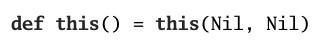  

前一例中给出的辅助构造方法构建一个空的队列。我们可以再提炼一下，让辅助构造方法接收一组初始队列元素：  

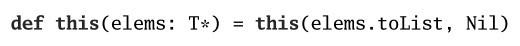  

回忆一下，**T\*用来表示重复的参数**（参考8.8节）。
另一种可能是添加一个工厂方法来从这样一组初始元素来构建队列。一种不错的实现方式是定义一个跟Queue类同名的对象，并提供一个apply方法，如示例19.3所示：  

In [6]:
  class Queue[T] private ( //注意这里括号前的private
    private val leading: List[T],
    private val trailing: List[T]
  ) 
  {
    private def mirror = 
      if (leading.isEmpty) new Queue(trailing.reverse, Nil)
      else this
    def head = 
      mirror.leading.head
    def tail = { 
      val q = mirror; 
      new Queue(q.leading.tail, q.trailing) 
    }
    def append(x: T) = 
      new Queue(leading, x :: trailing)

    override def toString() =
      (leading ::: trailing.reverse) mkString ("Queue(", ", ", ")")
  }

  object Queue {
    // constructs a queue with initial elements `xs'
    def apply[T](xs: T*) = new Queue[T](xs.toList, Nil)
  }

defined class Queue
defined object Queue

<center>示例19.3 伴生对象中的apply工厂方法</center>

通过将这个对象跟Queue类放在同一个源文件中，我们就让对象成为了Queue类的伴生对象。在13.5节你曾看到伴生对象拥有与对应伴生类相同的访问权限。因此，Queue对象的apply方法可以创建一个新的Queue，尽管Queue类的构造方法是私有的。

注意，由于这个工厂方法的名称是apply，使用方代码可以用诸如Queue（1, 2, 3）这样的表达式来创建队列。这个表达式会展开成Queue. apply（1, 2, 3），因为Queue是对象而不是函数。这样一来，Queue在使用方看来，就像是全局定义的工厂方法一样。实际上，Scala并没有全局可见的方法，每个方法都必须被包含在某个对象或某个类当中。不过，通过在全局对象中使用名为apply的方法，可以支持看上去像是全局方法的使用模式。

### 备选方案：私有类

私有构造方法和私有成员只是隐藏类的初始化和内部表现形式的一种方式。另一种更激进的方式是隐藏类本身，并且只暴露一个反映类的公有接口的特质。

示例19.4的代码实现了这样一种设计。其中定义了一个Queue特质，声明了方法head、tail和enqueue。所有这三个方法都实现在子类 QueueImpl中，这个子类本身是对象Queue的一个private的内部类。这种做法暴露给使用方的信息跟之前一样，不过采用了不同的技巧。跟之 前逐个隐藏构造方法和成员方法不同，这个版本隐藏了整个实现类。

In [7]:
  trait Queue[T] {
    def head: T
    def tail: Queue[T]
    def enqueue(x: T): Queue[T]
  }
  
  object Queue {
  
    def apply[T](xs: T*): Queue[T] = 
      new QueueImpl[T](xs.toList, Nil)
  
    private class QueueImpl[T](//注意这里private写在calss前面,只继承了Queue特质
      private val leading: List[T],
      private val trailing: List[T]
    ) extends Queue[T] {
  
      def mirror = 
        if (leading.isEmpty)
          new QueueImpl(trailing.reverse, Nil)
        else 
          this
  
      def head: T = mirror.leading.head
  
      def tail: QueueImpl[T] = {
        val q = mirror
        new QueueImpl(q.leading.tail, q.trailing)
      }
  
      def enqueue(x: T) = 
        new QueueImpl(leading, x :: trailing)
      override def toString() =
        (leading ::: trailing.reverse) mkString ("Queue(", ", ", ")")
    }
  }

defined trait Queue
defined object Queue

In [8]:
val q = Queue[Int]() enqueue 1 enqueue 2
println(q)

Queue(1, 2)


q: Queue[Int] = Queue(1, 2)

<center>示例19.4 函数式队列的类型抽象</center>

## 19.3 型变注解
示例19.4定义的Queue是一个特质，而不是一个类型。Queue不是类型，因为它接收一个类型参数。
因此，我们并不能创建类型为Queue的变量：

```scala
def doesNotCompile(q: Queue) = {}

cmd2.sc:1: trait Queue takes type parameters
def doesNotCompile(q: Queue) = {}
                      ^Compilation Failed

Compilation Failed
```

反而，Queue特质让我们可以指定参数化（parameterized）的类型，比如Queue[String]、Queue[Int]、Queue[AnyRef]等：

In [9]:
def doesCompile(q: Queue[AnyRef]) = {}

defined function doesCompile

所以，Queue是一个特质，而Queue[String]是一个类型。Queue也被称作类型构造方法（type constructor），因为我们可以通过指定类型参数来构造一个类型（这跟通过指定值参数来构造对象实例的普通构造方法的道理是一样的）。类型构造方法Queue能够“生成”成组的类型，包括Queue[Int]、Queue[String]和Queue[AnyRef]。

也可以说Queue是一个泛型（generic） 的特质（接收类型参数的类和特质是“泛型”的，但它们生成的类型是“参数化”的，而不是泛型的）。“泛型”的意思是我们用一个泛化的类或特质来定义许许多 多具体的类型。举例来说，示例19.4中的Queue特质就定义了一个泛型的队列。Queue[Int]和Queue[String]等就是那些具体的类型。

类型参数和子类型这两个概念放在一起，会产生一些有趣的问题。例如，通过Queue[T]生成的类型之间，有没有特殊的子类型关系？更确切地说， Queue[String]应不应该被当作Queue[AnyRef]的子类型？

或者更通俗地说，如果S是类型T的子类型，那么Queue[S]应不应该被当作Queue[T]的子类型？如果是，可以说Queue特质在类型参数T上是协变的（convariant） （或者说“灵活的”）。由于它只有一个类型参数，也可以简单地说Queue是协变的。**协变的Queue意味着我们可以传入一个Queue[String] 到前面的doesCompile方法，这个方法接收的是类型为Queue[AnyRef]的值参数**。

直观地讲，所有这些看上去都OK，因为一个String的队列看上去就像是一个Any Ref的队列的特例。**不过在Scala中，泛型类型默认的子类型规则是不变的（nonvariant） （或者说“刻板的”）**。也就是说，像示例19.4那样定义的Queue，不同元素类型的队列之间永远不会存在子类型关系。Queue[String]不能 当作Queue[AnyRef]来使用。不过，我们可以修改Queue类定义的第一行来要求队列的子类型关系是协变（灵活）的：

In [10]:
  trait Queue[+T] {
    def head: T
    def tail: Queue[T]
    //def enqueue(x: T): Queue[T]
  }

defined trait Queue

在类型形参前面加上+表示子类型关系在这个参数上是协变（灵活）的。通过这个字符，我们告诉Scala我们要的效果是，Queue[String]是Queue[AnyRef]的子类型。编译器会检查Queue的定义符合这种子类型关系的要求。
除了+，还有-可以作为前缀，表示逆变（contravariance）的子类型关系。如果Queue的定义是下面这个样子：

In [11]:
  trait Queue[-T] {
    //def head: T
    def tail: Queue[T]
    def enqueue(x: T): Queue[T]
  }

defined trait Queue

那么如果T是类型S的子类型，则表示Queue[S]是Queue[T]的子类型（这对于队列的例子而言很出人意料！）。类型参数是协变的、逆变的还是不变的，被称作类型参数的型变（variance）。可以放在类型参数旁边的+和-被称作型变注解（variance annotation）。

在纯函数式的世界中，许多类型都自然而然是协变（灵活）的。不过，当我们引入可变数据之后，情况就会发生变化。要搞清楚为什么，考虑这样一个简单的可被读写的单元格，如示例19.5所示。

In [12]:
class Cell[T](init: T) {
    private[this] var current = init
    def get = current
    def set(x: T) = {current = x}
}

defined class Cell

<center>示例19.5 一个不变的（刻板的）Cell类</center>

示例19.5中的类型Cell被声明为不变（刻板）的。为了讨论的需要，我们暂时假定Cell定义成了协变的（即class Cell[+T]），且通过了Scala编译器的检查（实际上并不会，稍后我们会讲到原因）。那么我们就可以构建出如下这组有问题的语句：

In [13]:
val c1 = new Cell[String]("abc")

c1: Cell[String] = ammonite.$sess.cmd11$Helper$Cell@5207e6ed

```scala
val c2: Cell[Any] = c1

cmd10.sc:1: type mismatch;
 found   : ammonite.$sess.cmd9.wrapper.cmd8.Cell[String]
 required: cmd10.this.cmd8.Cell[Any]
Note: String <: Any, but class Cell is invariant in type T.
You may wish to define T as +T instead. (SLS 4.5)
val c2: Cell[Any] = c1
                    ^Compilation Failed

Compilation Failed
```

In [14]:
val s: String = c1.get

s: String = "abc"

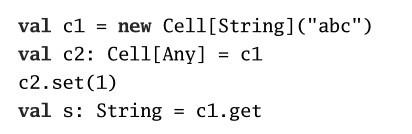  

单独看每一句，这四行代码都是OK的。第一行创建了一个字符串的单元格，并将它保存在名为c1的val中。第二行定义了一个新的val——c2，类型为 Cell[Any]，并用c1初始化。这是OK的，因为Cell被认为是协变的。第三行将c 2这个单元格的值设为1。这也是OK的，因为被赋的值1是c2的元素类型Any的实例。最后一行将c1的元素值赋值给一个字符串。不过放在一起，这四行代码产生的效果是将整数1赋值给了字符串s。这显然有悖于类型约束。

我们应该将运行时的错误归咎于哪一步操作呢？一定是第二行， 因为在这一行我们用到了协变的子类型关系。其他的语句都太简单和基础了。因此， **String的Cell并不同时是Any的Cell，因为有些我们能对Any的Cell做的事并不能对String的Cell做**。举例来说，我们并不能对 String的Cell使用参数为Int的set。

事实上，如果将C e l l的协变版本传给Scala编译器，我们将得到下面的编译期错误：

```scala
class Cell[+T](init: T) {
    private[this] var current = init
    def get = current
    def set(x: T) = {current = x}
}

cmd11.sc:4: covariant type T occurs in contravariant position in type T of value x
    def set(x: T) = {current = x}
            ^Compilation Failed

Compilation Failed
```

### 型变和数组
将这个行为跟Java的数组相比较会很有趣。从原理上讲，数组跟单元格很像，只不过数组可以有多于一个元素。尽管如此，数组在Java中是被当作协变的来处理的。

我们可以仿照前面的单元格交互来尝试Java数组的例子：  
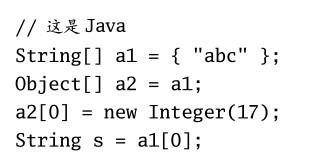   
如果执行这段代码，你会发现它能够编译成功，不过在运行时，当a2[0]被赋值成一个Integer，程序会抛出ArrayStoreException：  
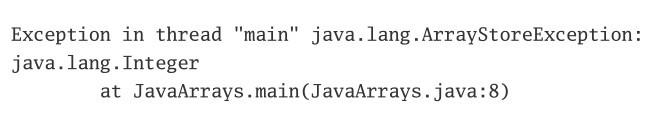  
发生了什么？Java在运行时会保存数组的元素类型。每当数组元素被更新，都会检查新元素值是否满足保存下来的类型要求。如果新元素值不是这个类型的实例，就会抛出ArrayStoreException。

你可能会问Java为什么会采纳这样的设计，看上去既不安全，运行开销也不低。当被问及这个问题时，Java语言的主要发明人James Gosling是这样回答的：他们想要一种简单的手段来泛化地处理数组。举例来说，它们想要用下面这样的接收一个Object数组的方法来对数组的所有元素排序：  
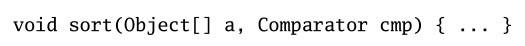  

需要协变的数组，才能让任意引用类型的数组得以传入这个方法。当然了，随着Java泛型的引入，这样的sort方法可以用类型参数来编写，这样一来就不再需要协变的数组了。不过由于兼容性的原因，直到今天Java还保留了这样的做法。

Scala在这一点上比Java做得更纯粹，它并不把数组当作是协变的。如果我们尝试将数组的例子的前两行翻译成Scala，就像这样：

In [15]:
val a1 = Array("abc")

a1: Array[String] = Array("abc")

```scala
val a2:Array[Any] = a1


cmd12.sc:1: type mismatch;
 found   : Array[String]
 required: Array[Any]
Note: String <: Any, but class Array is invariant in type T.
You may wish to investigate a wildcard type such as `_ <: Any`. (SLS 3.2.10)
val a2:Array[Any] = a1
                    ^Compilation Failed

Compilation Failed
```

发 了什么？Scala将数组处理成不变（刻板）的，因此Array[String]并不会被当作是Array[Any]处理。不过，有时候我们需要跟 Java的历史方法交互，这些方法用Object数组来仿真泛型数组。举例来说，你可能会想以一个String数组为入参调用前面描述的那样一个sort 方法。Scala允许我们将元素类型为T的数组类型转换成T的任意超类型的数组：

In [16]:
val a2: Array[Object] = a1.asInstanceOf[Array[Object]]

a2: Array[Object] = Array("abc")

这个类型转换在编译时永远合法，且在运行时也永远会成功，因为JVM的底层运行时模型对数组的处理都是协变的，就跟Java语言一样。不过你可能在这之后得到ArrayStoreException，这也是跟Java一样的。

## 19.4 检查型变注解
既然你已经看到有一些型变不可靠的例子，你可能会想，什么样的类定义需要被拒绝，什么样的类定义能被接收呢？到目前为止，所有对类型可靠性的违背都涉及可被 重新赋值的字段或数组元素。与此相对应地，纯函数式实现的队列看上去是协变的不错的候选人。不过，通过如下的例子你会看到，即便没有可被重新赋值的字段， 还是有办法能“刻意地做出”（engineer）不可靠的情况。

要构建这样一个例子，我们先假定示例19.4定义的队列是协变的。然后，创建一个特别针对元素类型Int的队列子类，重写enqueue方法：  
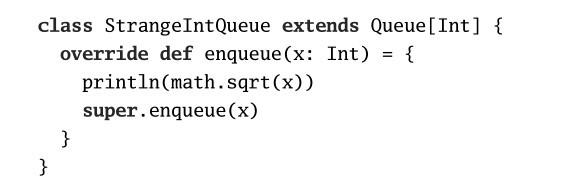  
StrangeIntQeueu的enqueue方法会先打印出（整数）入参的平方根，然后再处理追加操作。
现在，我们可以用两行代码做出一个反例：  
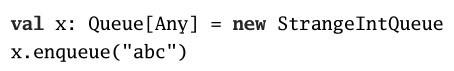  
两行代码中的第一行是合法的，因为StringIntQueue是Queue[Int]的子类，并且（假定队列是协变的）Queue[Int]是 Queue[Any]的子类型。第二行也是合法的，因为我们可以追加一个String到Queue[Any]中。不过，两行代码结合在一起，最终的效果是 对一个字符串执行了平方根的方法，这完全讲不通。

显然，并不仅仅只有可变字段能让协变类型变得不可靠。还有更深层次的问题。一旦泛型参数类型作为方法参数类型出现，包含这个泛型参数的类或特质就不能以那个类型参数做协变。

对于队列而言，enqueue方法违背了这个条件：  
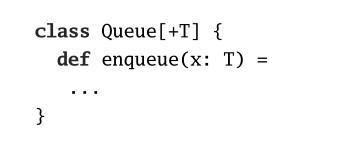  
通过Scala编译器运行上面这样一个修改后的队列类会给出：通过Scala编译器运行上面这样一个修改后的队列类会给出：  
```scala
  class Queue[+T](
    private val leading: List[T], 
    private val trailing: List[T] 
  ) {
    ......
    def enqueue(x: T) = 
      new Queue(leading, x :: trailing)
      
    override def toString = 
      leading ::: trailing.reverse mkString ("Queue(", ", ", ")")
  }

cmd2.sc:18: covariant type T occurs in contravariant position in type T of value x
    def enqueue(x: T) = 
                ^Compilation Failed

Compilation Failed
```

**可被重新赋值的字段是如下规则的特例：用+注解的类型参数不允许用于方法参数的类型。正如我们在18.2节提到的，一个可被重新赋值的字段“var x: T”在Scala中被当作getter方法“def x: T”和setter方法“def x_=（y:T）”。我们看到setter方法有一个参数，其类型为字段类型T。因此这个类型不能是协变的。**

快速通道

在本节剩余部分，我们将描述Scala编译器检查型变注解的机制。如果你暂时对这样的细节不感兴趣，可以安全地跳到19.5节。需要理解的最重要的一点是 Scala编译器会检查你加在类型参数上的任何型变注解。例如，如果你尝试声明一个类型参数为协变的（添加一个+），但是有可能引发潜在的运行时错误，你的程序将无法通过编译。

为了验证型变注解的正确性，Scala编译器会对类或特质定义中的所有能出现类型参数的点归类为协变的（positive）、逆变的（negative）和不变的（neutral）。**所谓的“点”（position）指的是类或特质（从现在起我们将笼统地说“类”）中任何一个可以用类型参数的地方**。例如，每个方法值参数都是这样一个点，因为方法值参数有类型，因此类型参数可以出现在那个点。

编译器会检查类的类型参数的每一次使用。用+注解的类型参数只能用在协变点，而用-注解的类型参数只能用在逆变点。而没有型变注解的类型参数可以用在任何能出现类型参数的点，因此这也是唯一的一种能用在不变点的类型参数。
为了对类型参数点进行归类，编译器从类型参数声明开始，逐步深入到更深的嵌套层次。声明该类型参数的类的顶层的点被归类为协变点。更深的嵌套层次默认为跟包含它的层次相同，不过有一些例外情况归类会发生变化。**方法值参数的点被归类为方法外的“翻转”（flipped），其中协变点的翻转是逆变点，逆变点的翻转是协变点，而不变点的翻转仍然是不变点**。

除了方法值参数外，当前的归类在方法的类型参数上也会翻转。在类型的类型参数上，当前的归类也会翻转，比如C[Arg]中的Arg，具体取决于相应的类型参数的型变。如果C的类型参数加上了+注解，那么归类保持不变。而如果C的类型参数加上了-注解，那么当前的归类会翻转。如果C的类型参数没有型变注解，那么当前归类保持不变。

来看一个多少有些刻意的例子，考虑下面这个类的归类，若干点被标上了它们相应的归类，+（协变）或-（逆变）：  
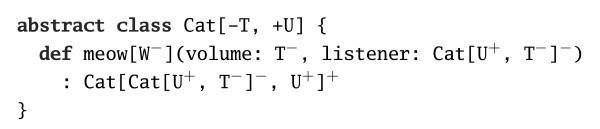  
类型参数W以及两个值参数volume和listener都位于逆变点。我们来重点看一下meow的结果类型，第一个Cat[U, T]的入参位于逆变点，因为Cat的首个类型参数T带上了-的注解。这个入参中的类型U再次出现在了协变点（两次翻转），而这个入参中的类型T仍然是处于协变点。

从这些讨论中我们不难看出要跟踪型变点相当不容易。不过别太担心， Scala编译器会帮你做这个检查。
一旦归类被计算出来，编译器会检查每个类型参数只被用在了正确归类的点。在本例中，T只用在了逆变点，而U只用在了协变点。因此Cat类是类型正确的。类 型参数W以及两个值参数volume和listener都位于逆变点。我们来重点看一下meow的结果类型，第一个Cat[U, T]的入参位于逆变点，因为Cat的首个类型参数T带上了-的注解。这个入参中的类型U再次出现在了协变点（两次翻转），而这个入参中的类型T仍然是处于协变点。

从这些讨论中我们不难看出要跟踪型变点相当不容易。不过别太担心，Scala编译器会帮你做这个检查。

一旦归类被计算出来，编译器会检查每个类型参数只被用在了正确归类的点。在本例中，T只用在了逆变点，而U只用在了协变点。因此Cat类是类型正确的。

## 19.5 下界
回到Queue类。你看到了，先前示例19.4中的Queue[T]定义不能以T协变，因为T作为enqueue方法的参数类型出现，而这是一个逆变点。

幸运的是，有一个办法可以解决：可以通过多态让enqueue泛化（即给enqueue方法本身一个类型参数）并对其类型参数使用下界（lower bound）。示例19.6给出了实现这个想法的新Queue。

In [17]:
class Queue[+T] (private val leading: List[T],private val trailing: List[T]) {
    def enqueue[U >: T](x: U) =//限制了x的下界是T
        new Queue[U](leading, x :: trailing) 
}

defined class Queue

<center>示例19.6 带有下界的类型参数</center>

新的定义给enqueue添加了一个类型参数U，并用“U >: T”这样的语法定义了U的下界为T。**这样一来，U必须是T的超类型**。[1]现在enqueue的参数类型为U而不是T，方法的返回值是Queue[U]而不是Queue[T]。

举例来说，假定有一个Fruit类和两个子类Apple和Orange。按照Queue类的新定义，可以对Queue[Apple]追加一个Orange，其结果是一个Queue[Fruit]。

修改过后的enqueue定义是类型正确的。直观地讲，如果T是一个比预期更具体的类型（例如相对Fruit而言的Apple），那么对enqueue的调用依然可行，因为U（Fruit）仍然是T（Apple）的超类型。[2]

enqueue的新定义显然比原先的定义更好，因为它更通用。不同于原先的版本，新的定义允许我们追加任意队列类型T的超类型U的元素，并得到Queue[U]。通过这一点加上队列的协变，获得了一种很自然的方式对不同的元素类型的队列灵活地建模。

这显示出型变注解和下标配合得很好。它们是类型驱动设计（type-driven design）的绝佳例子，在类型驱动设计中，接口的类型引导我们做出细节的设计和实现。在队列这个例子中，很可能一开始并不会想到用下界来优化 enqueue的实现。不过你可能已经决定让队列支持协变，这种情况下编译器会指出enqueue的型变错误。通过添加下界来修复这个型变错误让 enqueue更加通用，也让整个队列变得更加好用。

这也是Scala倾向于声明点（declaration-site）型变而不是使用点（use-site）型变的主要原因，Java的通配处理采用的是后者。如果采用使用点型变，我们在设计类的时候只能靠自己。最终是类的使用方来通配，而如果他们搞错了，一些重要的实例方法就不再可用了。型变是个很难办的东西，用户经常会搞错，然后得出通配和泛型过于复杂的结论。而如果采用定义点（definition-site）型变（其实跟声明点型变是一回事），可以向编译器表达我们的意图，然后编译器会帮助我们复核那些我们想要使用的方法是真的可用。

## 19.6 逆变
本章到目前为止的例子不是协变的就是不变的。不过在有的场景下逆变是自然的。参考示例19.7的输出通道特质：

In [18]:
trait OutputChannel[-T] {
    def write(x: T)
}

defined trait OutputChannel

<center>示例19.7 逆变的输出通道</center>

这里的OutputChannel被定义为以T协变。因此，一个AnyRef的输出通道就是一个String的输出通道的子类。虽然看上去有违直觉，实际上是讲得通的。我们能对一个OutputChannel[String]做什么，唯一支持的操作是向它写一个String。同样的操作，一个 OutputChannel[AnyRef]也能够完成。因此可以安全地用一个OutputChannel[AnyRef]来替换 OutputChannel[String]。与之相对应，在需要OutputChannel[AnyRef]的地方用 OutputChannel[String]替换则是不安全的。毕竟，可以向OutputChannel[AnyRef]传递任何对象，而 OutputChannel[String]要求所有被写的值都是字符串。

**上述推理指向类型系统设计的一个通用原则：如果在任何需要类型U的值的地方，都能用类型T的值替换，那么就可以安全地假定类型T是类型U的子类型。这被称作李氏替换原则（Liskov Substitution Principle）。如果T支持跟U一样的操作，而T的所有操作跟U中相对应的操作相比，要求更少且提供更多的话，该原则就是成立的**。在输出通道的例子中，OutputChannel[AnyRef]可以是OutputChannel[String]的子类型，因为这两个类型都支持相同的write操作，而这个操作在OutputChannel[AnyRef]中的要求比OutputChannel[String]要求更少。“更少”的意思是前者只要 求入参是AnyRef，而后者要求入参是String。

有时候，协变和逆变会同时出现在同一个类型中。一个显著的例子是Scala的函数特质。举例来说，当我们写下函数类型A => B,Scala会将它展开成Function1[A, B]。标准类库中的Function1同时使用了协变和逆变：Function1特质在函数入参类型S上协变，而在结果类型T上逆变，如示例19.8所 示。这一点满足李氏替换原则，因为入参是函数对外的要求，而结果是函数向外提供的返回值。

In [19]:
trait Function1[-S, +T] {
    def apply(x: S): T
}

defined trait Function1

<center>示例19.8 Function1的协变和逆变</center>

参考示例19.9给出的应用程序。在这里，Publication类包含了一个参数化的字段title，类型为String。Book类扩展了 Publication并将它的字符串参数String转发给超类的构造方法。Library单例对象定义了一个书的集和一个printBookList 方法，该方法接收一个名为info的函数，函数的类型为Book => AnyRef。换句话说，printBookList方法的唯一参数是一个接收一个Book入参并返回AnyRef的函数。Customer应用程序定义 了一个getTitle方法，这个方法接收一个Publication作为其唯一参数并返回一个String，也就是传入的Publication的标题（title）。

In [20]:
class Publication(val title: String)
class Book(title: String) extends Publication(title)

object Library {
val books: Set[Book] =
 Set(
   new Book("Programming in Scala"),
   new Book("Walden")
 )
def printBookList(info: Book => AnyRef) = {
 for (book <- books) println(info(book))
}
}

//object Customer extends App {
def getTitle(p: Publication): String = p.title
Library.printBookList(getTitle)
//}

Programming in Scala
Walden


defined class Publication
defined class Book
defined object Library
defined function getTitle

<center>示例19.9 函数参数型变的展示</center>

现在我们来看一下Customer的最后一行。这一行调用了Library的printBookList，并将getTitle打包在一个函数值传入：  
`Library.printBookList(getTitle)`  
这一行能够通过类型检查，尽管函数的结果类型String是printBookList的info参数的结果类型AnyRef的子类型。这段代码能通过编译是因为函数的结果类型被声明为是协变的（示例19.8中的+T）。如果看一下printBookList的实现，我们就能明白为什么这是讲得通的。

printBookList方法会遍历书的列表并对每本书调用传入的函数。它将info返回的AnyRef结果传入println，由它调用toString并打印出结果。这个动作对于String以及AnyRef的任何子类都可行，这就是函数结果类型协变的意义。

现在我们来考察传入printBookList方法的函数的参数类型。尽管printBookList的参数类型声明为Book，我们传入的 getTitle函数接收的却是Publication，它是Book父类型。这之所以可行，背后的原因是：由于printBookList的参数类型是Book,printBookList的方法体只能将Book传给这个函数，而由于getTitle的参数类型是Publication，这个函数的函数体只能对其参数p访问那些在Publication类中声明的成员。由于Publication中声明的所有方法 都在其子类Book中可用，一切都应该可以工作，这就是函数参数类型逆变的意义。参考图19.1。  
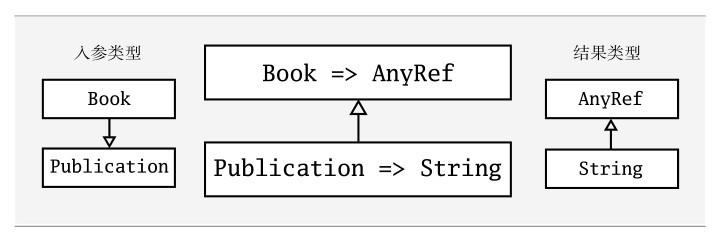  
<center>图19.1 函数类型参数的协变和逆变</center>  
示例19.9中的代码之所以能通过编译，是因为Publication => String是Book => AnyRef的子类型，如图19.1中部所示。由于Function1的结果类型定义为协变，图中右部显示的两个结果类型的继承关系跟中部函数的继承关系 的方向是相同的。而由于Function1的参数类型定义为逆变，图中左部显示的两个参数类型的继承关系跟函数的继承关系的方向是相反的。

## 19.7 对象私有数据
到目前为止我们看到的Queue类有一个问题，当leading列表为空时，如果连续调用多次head，它的mirror操作会反复地从trailling 拷贝元素到leading。这种无谓的拷贝可以通过谨慎地添加副作用的方式避免。示例19.10展示了Queue的新实现，对连续的head操作最多只执 行一次trailing到leading的调整。
跟前面的版本的区别在于leading和trailing是可被重新赋值的变量，而mirror从trailing到leading的反向拷贝对当前队列有个副作用，而不是返回新的队列。这个副作用纯粹是Queue内部的，由于leading和trailing是私有变量，这个副作用对Queue的使用方并不可见。因此按第18章的术语，新版本的Queue虽然事实上包含了可被重新赋值的字段，它定义的仍然是纯函数式对象。

In [21]:
 class Queue[+T] private (
   private[this] var leading: List[T], 
   private[this] var trailing: List[T]
 ) {

   private def mirror() = 
     if (leading.isEmpty) {
       while (!trailing.isEmpty) {
         leading = trailing.head :: leading
         trailing = trailing.tail
       }
     }

   def head: T = { 
     mirror()
     leading.head 
   }

   def tail: Queue[T] = { 
     mirror()
     new Queue(leading.tail, trailing) 
   }

   def enqueue[U >: T](x: U) = 
     new Queue[U](leading, x :: trailing)
 }

defined class Queue

<center>示例19.10 优化后的函数式队列</center>

你可能会怀疑这段代码是否能通过Scala的类型检查。毕竟队列现在包含了两个协变的参数类型T的可被重新赋值的字段。这不是违背了型变规则吗？的确有这个嫌疑，不过leading和trailing带上了一个private[this]的修饰符，因而是对象私有的。

我们在13.5节提到过，**对象私有的成员只能从定义它们的对象内部访问**。而从定义变量的同一个对象访问这些变量并不会造成型变的问题。直观地理解，如果我们要构造一个型变会引发类型错误的场景，需要引用一个从静态类型上比定义该对象更弱的对象，而对于访问对象私有值的情况，这是不可能出现的。

Scala 的型变检查对于对象私有定义有一个特殊规则。在检查带有+或的类型参数只应出现在相同型变归类的位点时，会忽略掉对象私有的定义。因此，示例19.10的 代码可以正常编译。但是，如果漏掉了这两个private修饰符的[this]限定词，我们将看到如下类型错误：  
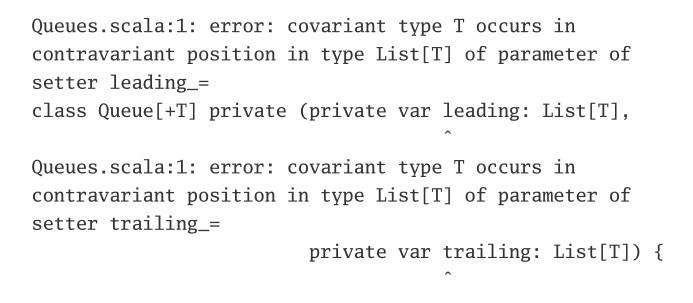

## 19.8 上界
在示例16.1（323页）中，展示了一个接收比较函数作为第一个入参，以及一个要排序的列表作为第二个（柯里化的）入参的归并排序函数。也可以用另一种方式来组织这样一个排序函数，那就是要求列表的类型是混入了Ordered特质的。就像我们在12.4节提到的，通过混入Ordered并实现 Ordered特质的抽象方法compare，可以让类的使用方代码用<、>、<=和>=来比较这个类的实例。例如，示例 19.11中混入了Ordered的Person类。

有了这样的定义，我们可以像这样来比较两个人：

In [22]:
class Person(val firstName: String, val lastName: String) 
    extends Ordered[Person] {
    def compare(that: Person) = {
        val lastNameComparison = lastName.compareToIgnoreCase(that.lastName)
        if(lastNameComparison != 0)
            lastNameComparison
        else
            firstName.compareToIgnoreCase(that.firstName)
    }
    override def toString = firstName + " " + lastName
}

defined class Person

In [23]:
val robert = new Person("Robert", "Jones")

robert: Person = Robert Jones

In [24]:
val sally = new Person("Sally", "Smith")

sally: Person = Sally Smith

In [25]:
robert < sally

res24: Boolean = true

为了确保传入到这个新的排序函数的列表类型混入了Ordered，需要使用上界（upper bound）。上界的指定方式跟下界类似，只不过不是用表示下界的>:符号，而是用<：符号，如示例19.12所示。

In [26]:
def orderedMergeSort[T <: Ordered[T]](xs: List[T]): List[T] = {
    def merge(xs: List[T], ys: List[T]): List[T] = (xs, ys) match {
        case(Nil, _) => ys
        case(_, Nil) => xs
        case(x::xs1, y::ys1) =>
            if(x < y) x::merge(xs1,ys)
            else y::merge(xs,ys1)
    }
    val n = xs.length / 2
    if(n==0) xs
    else {
        val (ys, zs) = xs splitAt n
        merge(orderedMergeSort(ys),orderedMergeSort(zs))
    }
}

defined function orderedMergeSort

通过“T <: Ordered[T]”这样的语法，我们告诉编译器类型参数T有一个上界Order[T]。这意味着传入orderedMergeSort的列表的元素类 型必须是Ordered的子类型。所以，我们就能将List[Person]传给orderedMergeSort，因为Person混入了 Ordered。

参考下面的列表：

In [27]:
val people = List(
    new Person("Larry", "Wall"),
    new Person("Anders", "Hejlsberg"),
    new Person("Lifoo", "Haha")
)

people: List[Person] = List(Larry Wall, Anders Hejlsberg, Lifoo Haha)

由于这个列表的元素类型Person混入了Ordered[Person]（也就是说它是Ordered[Person]的子类型），可以将这个列表传入orderedMergeSort：

In [28]:
val sortedPeople = orderedMergeSort(people)

sortedPeople: List[Person] = List(Lifoo Haha, Anders Hejlsberg, Larry Wall)

虽然示例19.12中的排序函数对于说明上界这个概念很有帮助，它实际上并不是Scala中利用Ordered特质设计排序函数的最通用的方式。

举例来说，我们并不能用orderedMergeSort来对整数列表进行排序，因为Int类并不是Ordered[Int]的子类型：

```scala
val wontCompile = orderedMergeSort(List(3, 2, 1))



cmd13.sc:1: inferred type arguments [Int] do not conform to method orderedMergeSort's type parameter bounds [T <: Ordered[T]]
val wontCompile = orderedMergeSort(List(3, 2, 1))
                  ^cmd13.sc:1: type mismatch;
 found   : List[Int]
 required: List[T]
val wontCompile = orderedMergeSort(List(3, 2, 1))
                                       ^Compilation Failed

Compilation Failed
```

在21.6节，我们将展示如何使用隐式转换（implicit conversion）和上下文界定（context bound）来实现一个更通用的解决方案。

## 19.9 结语
本章介绍了信息隐藏的若干技巧：私有构造方法、工厂方法、类型抽象和对象私有成员，还介绍了如何指定数据类型型变以及型变对于类实现意味着什么。最后介绍了两种帮助我们更灵活地使用型变标注的技巧：对方法类型参数使用下界，以及对局部字段和方法使用private[this]注解。

[1].超类型和子类型关系是反身（reflexive）的，意思是一个类型同时是自己的超类型和子类型。尽管T是U的下界，你仍然可以将一个T传入enqueue。  
[2].从技术上讲，这里发生的情况是对于下界而言，协变和逆变点发生了翻转。类型参数U出现在逆变点（1次翻转），而下界（>: T）是一个协变点（2次翻转）。

## 笔记
### 形变规则要求
用+注解的类型参数只能用在协变点，而用-注解的类型参数只能用在逆变点。而没有型变注解的类型参数可以用在任何能出现类型参数的点，因此这也是唯一的一种能用在不变点的类型参数。用+注解的类型参数只能用在协变点，而用-注解的类型参数只能用在逆变点。而没有型变注解的类型参数可以用在任何能出现类型参数的点，因此这也是唯一的一种能用在不变点的类型参数。

方法值参数的点被归类为方法外的“翻转”（flipped），其中协变点的翻转是逆变点，逆变点的翻转是协变点，而不变点的翻转仍然是不变点方法值参数的点被归类为方法外的“翻转”（flipped），其中协变点的翻转是逆变点，逆变点的翻转是协变点，而不变点的翻转仍然是不变点。

除了方法值参数外，当前的归类在方法的类型参数上也会翻转。在类型的类型参数上，当前的归类也会翻转，比如C[Arg]中的Arg，具体取决于相应的类型参数的型变。如果C的类型参数加上了+注解，那么归类保持不变。而如果C的类型参数加上了-注解，那么当前的归类会翻转。如果C的类型参数没有型变注解，那么当前归类保持不变。除了方法值参数外，当前的归类在方法的类型参数上也会翻转。在类型的类型参数上，当前的归类也会翻转，比如C[Arg]中的Arg，具体取决于相应的类型参数的型变。如果C的类型参数加上了+注解，那么归类保持不变。而如果C的类型参数加上了-注解，那么当前的归类会翻转。如果C的类型参数没有型变注解，那么当前归类保持不变。

1. 一旦泛型参数类型作为方法参数类型出现，包含这个泛型参数的类或特质就不能以那个类型参数做协变。